In [1]:
import pandas as pd
import numpy as np
import math 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tarfile
import io
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
## data loading
data_ar=pd.read_csv('noaa_ar_1996_2019.csv') ## Active region data
data_sep=pd.read_csv('GSEP_List.csv') ## Also available: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DZYLHK&version=3.0
data_hcme=pd.read_html("https://cdaw.gsfc.nasa.gov/CME_list/halo/halo.html") ## Loading Halo CME data

In [3]:
def load_clean_ar(data_ar):
    '''
    This function will load the raw noaa active region data and returns
    the cleaned datset following the steps described in the function. This
    module will select the subset of required columns from the raw dataset.
    
    Inputs : 
    -A pandas dataframe which were loaded in the data loading phase. (data_ar)
    
    Returns:
    - A pandas dataframe with cleaned noaa active region data
    '''
    ar_df=data_ar
    ## Selecting subset of the columns
    active_region_df=ar_df[["ar_time","noaa_ar_no","central_meridian_dist","latitude"]]
    
    ## Extracting the date part from the column ar_time
    active_region_df["ar_time"]=pd.to_datetime(active_region_df["ar_time"]).dt.date
    
    ## Longitude coordinates ranging outside [-180,180] will be transformed to the correct values
    ## For example: -184 will be converted to 176, which will now be on the east direction.
    ## All values ranging outside the range [-180,180] will be shifted to the other direction using the transformation
    active_region_df["central_meridian_dist"]=np.where(active_region_df["central_meridian_dist"]>180,
                                     active_region_df["central_meridian_dist"]-360,active_region_df["central_meridian_dist"] )
    active_region_df["central_meridian_dist"]=np.where(active_region_df["central_meridian_dist"]<-180,
                                     active_region_df["central_meridian_dist"]+360,active_region_df["central_meridian_dist"] )
    
    return active_region_df


In [4]:

def sep_load_clean(data_sep):
    '''
    Function to load and clean SEP data.
    
    Input : 
    - A pandas dataframe consisting of SEP meta data, which were loaded in data loading stage
    
    Returns:
    Cleaned pandas dataframe for SEP meta data
    '''
    sep_df=data_sep
    ## Conversion of coordinates into numeric type
    sep_df["fl_lon"]=pd.to_numeric(sep_df["fl_lon"], errors='coerce')
    sep_df["fl_lat"]=pd.to_numeric(sep_df["fl_lat"], errors='coerce')
    
    ## Conversion of timestamp to datetime
    sep_df["timestamp"]= pd.to_datetime(sep_df["timestamp"])
    sep_df["timestamp"]=sep_df["timestamp"].dt.date
    
    return sep_df

In [5]:

def bins_formation(num_lon_bins=None ,num_lat_bins=None, customized_lon_bins=None,customized_lat_bins=None):
    
    '''
    Function to define custom spatial coordinates binning strategy.
    This function will either divide the lat, lon space into equal width bins or 
    the custom bins
    
    Inputs:
    num_lon_bins : An integer(n) which will make n numbers of equal width bins between [-180,180] 
    ---- binning lon coordinates
    
    num_lat_bins : An integer(n) which will make n numbers of equal width bins between [-90,90]
    -----binning of lat coordinates
    
    customized_lon_bins : A list to store start point & end points of each bin for lon coordinates
    defined by custom bin strategy. For example : [-180,-90,-72,-54,-36,-18,0,18,36,54,72,90,180]--
    Passing this list will create 12 bins between [-180,180]. The custom list must be in the increasing order 
    of endpoints of bins and should start from -180 & ends at 180 to split the full space.
    ----
    
    customized_lat_bins : A list to store start point & end points of each bin for lat coordinates
    defined by custom bin strategy. For example : [-90,-72,-54,-36,-18,0,18,36,54,72,90]--
    Passing this list will create 10 bins between [-90,90]. The custom list must be in the increasing order 
    of endpoints of bins and should start from -90 & ends at 90 to split the full space.
    
    
    Returns: A tuple (lon_bins,lat_bins)
    lon_bins: A list consisting start point & end points for all the lon bins
    lat_bins: A list consisting start point & end points for all thr lat bins
    
    '''
    
    
    
    if num_lat_bins!=None :
        ## Creating equal width lat bins
        lat_bins=[-90+x*(180/num_long_bins) for x in range(num_long_bins+1)]
    if num_lon_bins!=None:
        ## Equal width lon bins
        lon_bins=[-180+x*(360/num_lon_bins) for x in range(num_lon_bins+1)]
    if customized_lon_bins!=None:
        ## If customized binning strategy is defined
        lon_bins=customized_lon_bins
    if customized_lat_bins!=None:
        ## If customized binning strategy is defined
        lat_bins=customized_lat_bins
        
    return (lon_bins,lat_bins)

In [6]:
## Calling bins formation with defined binning strategy
bins=bins_formation(customized_lon_bins=[-180,-90,-72,-54,-36,-18,0,18,36,54,72,90,180],
              customized_lat_bins=[-90,-72,-54,-36,-18,0,18,36,54,72,90])

In [7]:
def merge_sep_ar(sep_df,ar_df,bins):
    
    '''
    A function to join SEP Cleaned data and Active region cleaned data. It will
    also form bins on the active regions central_meridian_dist(lon) and latitude(lat)
    columns respectively
    
    Inputs:
    sep_df - A pandas dataframe consisting SEP meta data
    ar_df - A pandas dataframe consisting active regions data
    bins - A tuple consisting of lon & lat binning strategy
    
    
    Returns:
    A merged pandas dataframe with SEP, noaa active regions data and corresponding lon, lat bins
    '''
   ## Joining two dataframes on noaa active region number and the respective timestamp
    merged_df = pd.merge(sep_df, ar_df,  how='left', left_on=['noaa_ar','timestamp'], 
                  right_on = ['noaa_ar_no','ar_time'])
    ## Defining bins and storing bins in the new column of dataframe
    merged_df['AR_Lat_bin_names'] = pd.cut(merged_df['latitude'], bins[1],include_lowest=True)
    merged_df['AR_Long_bin_names'] = pd.cut(merged_df['central_meridian_dist'], bins[0],include_lowest=True)

    return merged_df

In [8]:
## Calling the defined function 
sep_df=sep_load_clean(data_sep) ## SEP Data
ar_df=load_clean_ar(data_ar)    ## noaa Active region
sep_ar_data=merge_sep_ar(sep_df,ar_df,bins) ## Merged DataFrame
sep_ar_data

,sep_index,pp_index,cdaw_sep_id,timestamp,cdaw_start_time,cdaw_max_time,cdaw_evn_max,cme_id,cme_launch_time,cme_1st_app_time,...,Fe_e_p_shock_notes,gsep_notes,slice_start,slice_end,ar_time,noaa_ar_no,central_meridian_dist,latitude,AR_Lat_bin_names,AR_Long_bin_names
0,gsep_001,psep_012,NaN,1986-02-04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AR from LMSAL,1986-02-03 21:25:00,1986-02-04 17:45:00,NaN,NaN,NaN,NaN,NaN,NaN
1,gsep_002,psep_013,NaN,1986-02-05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AR from LMSAL,1986-02-04 14:00:00,1986-02-06 08:35:00,NaN,NaN,NaN,NaN,NaN,NaN
2,gsep_003,psep_014,NaN,1986-02-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AR from LMSAL,1986-02-05 20:35:00,1986-02-07 13:25:00,NaN,NaN,NaN,NaN,NaN,NaN
3,gsep_004,psep_015,NaN,1986-02-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AR from LMSAL,1986-02-07 01:00:00,1986-02-08 22:20:00,NaN,NaN,NaN,NaN,NaN,NaN
4,gsep_005,psep_016,NaN,1986-02-10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,AR from LMSAL,1986-02-10 09:00:00,1986-02-12 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,gsep_338,NaN,cdaw_sep_148,2016-01-02,2016-01-02 00:15:00,2016-01-02 04:50:00,22.0,lasco_26928,2016-01-01 23:09:13,2016-01-01 23:24:00,...,NaN,NaN,2016-01-01 12:15:00,2016-01-02 12:45:00,2016-01-02,12473.0,73.0,-21.0,"(-36.0, -18.0]","(72.0, 90.0]"
338,gsep_339,NaN,cdaw_sep_149,2017-07-14,2017-07-14 04:40:00,2017-07-14 23:20:00,22.0,lasco_28753,2017-07-14 01:02:31,2017-07-14 01:25:00,...,NaN,NaN,2017-07-13 16:40:00,2017-07-16 19:40:00,2017-07-14,12665.0,30.0,-7.0,"(-18.0, 0.0]","(18.0, 36.0]"
339,gsep_340,NaN,cdaw_sep_150,2017-09-04,2017-09-04 22:30:00,2017-09-05 19:20:00,210.0,lasco_28869,2017-09-04 20:13:01,2017-09-04 20:36:05,...,NaN,NaN,2017-09-04 10:30:00,2017-09-06 12:30:00,2017-09-04,12673.0,2.0,-10.0,"(-18.0, 0.0]","(0.0, 18.0]"
340,gsep_341,NaN,cdaw_sep_151,2017-09-06,2017-09-06 12:35:00,2017-09-07 23:25:00,41.0,lasco_28874,2017-09-06 11:54:23,2017-09-06 12:24:00,...,NaN,Data corrected for spike,2017-09-06 00:35:00,2017-09-08 14:35:00,2017-09-06,12673.0,30.0,-9.0,"(-18.0, 0.0]","(18.0, 36.0]"


In [9]:
def gsep_bin_formation(x):
    
    '''
    A function to make bins on the gsep_pf_gt10MeV column
    
    Inputs : 
    x - A number
    
    Ouputs :
    Corresponding bin name
    '''
    
    if x <10:
        return 'S0'
    elif (x>=10) and (x<100):
        return 'S1'
    elif (x>=100) and (x<1000):
        return 'S2'
    elif (x>1000) and (x<10000):
        return 'S3'
    else:
        return 'S4'
## Calling the function to make bins of  gsep_pf_gt10_bins column using apply function   
sep_ar_data["gsep_pf_gt10_bins"]=sep_ar_data['gsep_pf_gt10MeV'].apply(gsep_bin_formation)   

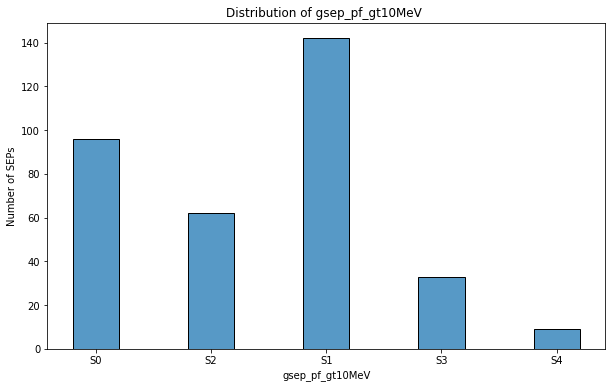

In [10]:
## Plotting Histogram of bins defined on gsep_pf_gt10_bins
fig, x = plt.subplots(figsize=(10,6))
ax=sns.histplot(data=sep_ar_data, x="gsep_pf_gt10_bins",shrink =0.4,ax=x).set(title='Distribution of gsep_pf_gt10MeV ',
                                                                               xlabel='gsep_pf_gt10MeV', 
                                                                               ylabel='Number of SEPs')


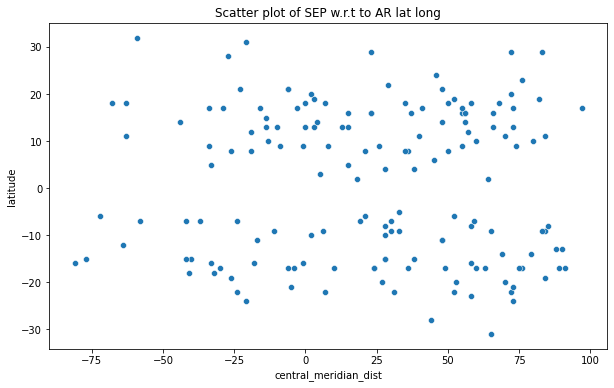

In [11]:
## Scatter Plot for central_meridian_dist and latitude of noaa active regions of SEPs
fig, x = plt.subplots(figsize=(10,6))
ax=sns.scatterplot(data=sep_ar_data, x="central_meridian_dist", y="latitude",ax=x).set(title=
                                                                               'Scatter plot of SEP w.r.t to AR lat long')

In [12]:
def groupby_bins(data_df,col_1,col_2,col_agg):
    
    '''
    This function will compute the aggregated counts of SEPs for each pair of 
    lon & lat bins defined
    
    Inputs :
    data_df - Merged dataframe
    col_1- First column used for grouping ( lat bins)
    col_2 -Second column used for grouping ( lat bins)
    col_agg- The column on which aggregation is done (sep_index)
    
    Returns :
    grop_bin_df- A dataframe which will store distinct pairs of bins and the count of SEPs for each of them
    
    '''
    
    
    groups = data_df.groupby([col_1, col_2])
    grop_bin_df=pd.DataFrame()
    ## Counting Number of SEPs for each pair of the spatial bins
    grop_bin_df[col_agg+'_count']=groups[col_agg].count()

    grop_bin_df=grop_bin_df.reset_index()
    return grop_bin_df
    

In [13]:
## Calling function to group dataframe. For 12 lon_bins & 10 lat bins, we got 120 different pairs
SEP_bin_df=groupby_bins(sep_ar_data,"AR_Lat_bin_names", "AR_Long_bin_names","sep_index")
SEP_bin_df

,AR_Lat_bin_names,AR_Long_bin_names,sep_index_count
0,"(-90.001, -72.0]","(-180.001, -90.0]",0
1,"(-90.001, -72.0]","(-90.0, -72.0]",0
2,"(-90.001, -72.0]","(-72.0, -54.0]",0
3,"(-90.001, -72.0]","(-54.0, -36.0]",0
4,"(-90.001, -72.0]","(-36.0, -18.0]",0
...,...,...,...
115,"(72.0, 90.0]","(18.0, 36.0]",0
116,"(72.0, 90.0]","(36.0, 54.0]",0
117,"(72.0, 90.0]","(54.0, 72.0]",0
118,"(72.0, 90.0]","(72.0, 90.0]",0


In [14]:
def load_clean_halo_cme(data_hcme,bins):
    
    '''
     A function to load and clean the Halo CME data
     
     Input : 
     -data_hcme : A pandas dataframe which were extracted in the data loading stage from the url:
     https://cdaw.gsfc.nasa.gov/CME_list/halo/halo.html
     
     - bins : A tuple which will consist list for two binning strategies
     
     
     Returns: 
     A dataframe which will consist Halo CME data
     
    '''
    
    
    
    table_MN = data_hcme
    ## Removing source location values consisting "Backside" or ends with b or having -- 
    patternDel = "Backside*|.*b|--.*"
    filter = table_MN[1]['Source Location'].str.contains(patternDel)
    Halo_df=table_MN[1][~filter]
    
    ## Formatting columns of dataframe
    df_split1=Halo_df['Source Location'].str.split('[NSEW?]|>', expand=True)
    df_split1.columns = ['g1', "Lat","Long",'g2']
    ## Direction string for the coordinates
    df_split2=Halo_df['Source Location'].str.split('\d+', expand=True)
    df_split2.columns = ["Lat_direction", "Long_direction","g3"]
    
    ## Converting coordinates values to numerical data types. Multiplying the coordinates with -1 if the direction
    ## is either S oe E
    cordinates_df=pd.concat([df_split1,df_split2],axis=1)
    cordinates_df["Lat"]=pd.to_numeric(cordinates_df["Lat"])
    cordinates_df["Long"]=pd.to_numeric(cordinates_df["Long"])
    cordinates_df["Lat"]=np.where(cordinates_df['Lat_direction'] == 'S',
                                           cordinates_df['Lat'] * -1,
                                           cordinates_df['Lat'])
    cordinates_df["Long"]=np.where(cordinates_df['Long_direction'] == 'E',
                                           cordinates_df['Long'] * -1,
                                           cordinates_df['Long'])
    
    HCME_df=pd.concat([Halo_df,cordinates_df[['Lat',"Long"]]],axis=1)
    
    ## Longitude coordinates ranging outside [-180,180] will be transformed to the correct values
    ## For example: -184 will be converted to 176, which will now be on the east direction.
    ## All values ranging outside the range [-180,180] will be shifted to the other direction using the transformation
    HCME_df["Long"]=np.where(HCME_df["Long"]<-180,HCME_df["Long"]+360,HCME_df["Long"] )
    HCME_df["Long"]=np.where(HCME_df["Long"]>180,HCME_df["Long"]-360,HCME_df["Long"] )
    
    
    ## Binning the dataframe 
    HCME_df['HCME_Lat_bin_names'] = pd.cut(HCME_df['Lat'], bins[1],include_lowest=True)
    HCME_df['HCME_Long_bin_names'] = pd.cut(HCME_df['Long'], bins[0],include_lowest=True)
    HCME_df=HCME_df.reset_index()
    HCME_df.rename(columns = {'index':'HCME_index'}, inplace = True)

    return HCME_df

In [15]:
## Calling function to get clean halo cme dataframe
HCME_df=load_clean_halo_cme(data_hcme,bins)

In [16]:
## Calling function to group dataframe. For 12 lon_bins & 10 lat bins, we got 120 different pairs 
HCME_bin_df=groupby_bins(HCME_df,'HCME_Lat_bin_names','HCME_Long_bin_names','HCME_index')

In [17]:
def laplacian_prob_smoothing(SEP_bin_df,HCME_bin_df,k=1):
    '''
    This function will merge both SEP grids dataframe and Halo CME dataframe. On the merged dataframe
    then the conditional probabilities of occurence of SEPs and Halo CMEs occuring together in spatial grids
    will be computed. The probabilities will be then distributed using Laplacian smoothing
    
    Laplacian smoothing---->           (count(A) +K)
                           P(A|B)=   ------------------  ; where k is constant number
                                     count(B)+K*Domain{X}
    
    Inputs : 
    SEP_bin_df - Grouped dataframe for SEP 
    HCME_bin_df - Grouped dataframe for Halo CME data
    k- An integer for laplacian smoothing
    
    Returns : 
    A merged data frame with laplacian smoothed probabilities  
    
    '''
    ## Merging the two dataframe on the active region spatial bins created for SEP data and Halo CME spatial bisn
    cond_prob_df=SEP_bin_df.merge(HCME_bin_df,how='inner',
                              left_on=['AR_Lat_bin_names','AR_Long_bin_names'], 
                                  right_on = ['HCME_Lat_bin_names','HCME_Long_bin_names'])
    ## Computed laplacian smoothing to distribute probabilities among zero probabilities
    cond_prob_df["Laplacian_smoothing"]=(cond_prob_df["sep_index_count"] +k)/ (cond_prob_df["HCME_index_count"] + (k*cond_prob_df.shape[0]))
    return cond_prob_df

In [18]:
## Calling the function 
lap_prob_df=laplacian_prob_smoothing(SEP_bin_df,HCME_bin_df,k=1)

In [19]:
## Making copy of the dataframe
final_lap_df=lap_prob_df.copy()

## Splitting the lat bins into two atomic values; start and end of the bins
final_lap_df[['Lat_bin_start','Lat_bin_end']]=final_lap_df['AR_Lat_bin_names'].astype(str).str.split(',',expand=True)
final_lap_df["Lat_bin_start"]=final_lap_df["Lat_bin_start"].str[1:]
final_lap_df["Lat_bin_end"]=final_lap_df["Lat_bin_end"].str[:-1]


## Splitting the lon bins into two atomic values; start and end of the bins
final_lap_df[['Lon_bin_start','Lon_bin_end']]=final_lap_df['AR_Long_bin_names'].astype(str).str.split(',',expand=True)
final_lap_df["Lon_bin_start"]=final_lap_df["Lon_bin_start"].str[1:]
final_lap_df["Lon_bin_end"]=final_lap_df["Lon_bin_end"].str[:-1]

final_lap_df=final_lap_df[["Lon_bin_start","Lon_bin_end","Lat_bin_start","Lat_bin_end","Laplacian_smoothing"]]

final_lap_df


,Lon_bin_start,Lon_bin_end,Lat_bin_start,Lat_bin_end,Laplacian_smoothing
0,-180.001,-90.0,-90.001,-72.0,0.008333
1,-90.0,-72.0,-90.001,-72.0,0.008333
2,-72.0,-54.0,-90.001,-72.0,0.008333
3,-54.0,-36.0,-90.001,-72.0,0.008333
4,-36.0,-18.0,-90.001,-72.0,0.008333
...,...,...,...,...,...
115,18.0,36.0,72.0,90.0,0.008333
116,36.0,54.0,72.0,90.0,0.008333
117,54.0,72.0,72.0,90.0,0.008333
118,72.0,90.0,72.0,90.0,0.008333


In [20]:
## Pivot table on spatial bins. Each element of the pivot table will denote the laplacian smoothing calculated for
## the respective pairs of spatial bins
piv = pd.pivot_table(lap_prob_df, values="Laplacian_smoothing",index=["AR_Lat_bin_names"], columns=["AR_Long_bin_names"], fill_value=0)
piv

AR_Long_bin_names,"(-180.001, -90.0]","(-90.0, -72.0]","(-72.0, -54.0]","(-54.0, -36.0]","(-36.0, -18.0]","(-18.0, 0.0]","(0.0, 18.0]","(18.0, 36.0]","(36.0, 54.0]","(54.0, 72.0]","(72.0, 90.0]","(90.0, 180.0]"
AR_Lat_bin_names,,,,,,,,,,,,
"(-90.001, -72.0]",0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
"(-72.0, -54.0]",0.008333,0.008333,0.008333,0.008333,0.008264,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
"(-54.0, -36.0]",0.008333,0.008333,0.008333,0.008333,0.008333,0.008197,0.008264,0.008264,0.008333,0.008333,0.008333,0.008197
"(-36.0, -18.0]",0.007299,0.008264,0.008065,0.016129,0.038462,0.015152,0.015267,0.023810,0.032000,0.040984,0.032000,0.007463
"(-18.0, 0.0]",0.006579,0.031496,0.023256,0.038168,0.037594,0.042857,0.028777,0.099291,0.047619,0.062016,0.078125,0.014184
"(0.0, 18.0]",0.006757,0.007752,0.031496,0.015385,0.058394,0.078014,0.074324,0.062069,0.069767,0.115385,0.047619,0.013245
"(18.0, 36.0]",0.007752,0.008264,0.016129,0.008130,0.031496,0.022901,0.022388,0.023810,0.031746,0.024194,0.032787,0.008197
"(36.0, 54.0]",0.008333,0.008264,0.008333,0.008333,0.008333,0.008333,0.008130,0.008333,0.008333,0.008333,0.008197,0.008333
"(54.0, 72.0]",0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


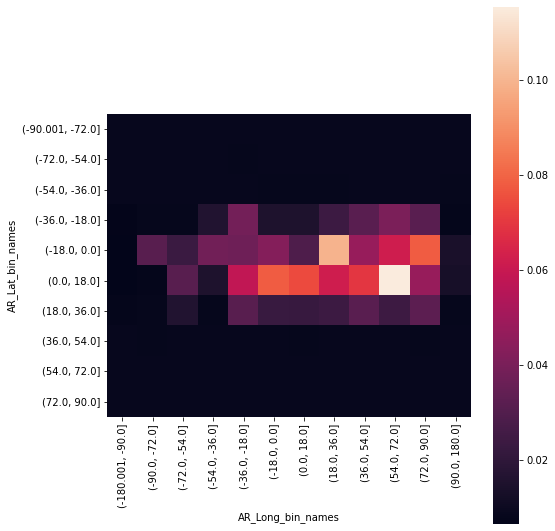

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot pivot table as heatmap using seaborn
fig, x = plt.subplots(figsize=(8,8))
pl = sns.heatmap(piv, square=True,ax=x)
plt.setp( pl.xaxis.get_majorticklabels(), rotation=90 )
plt.tight_layout()
plt.show()

# Time Series Visualization

In [22]:
def file_name_(x):
    '''
    Function to do string manipulation to create time series slice filename convention
    
    Inputs : 
    x - A string
    
    Returns:
    filename - String in the format yyyy-mm-dd_HH-MM.csv
    '''
    x_temp=x[:-3]
    filename=x_temp.replace(":","-")+".csv"
    return filename

In [23]:
def loading_ts_from_tar(t22,t23,t24,filename):
    
    '''
    A function to load time series slice into dataframe presents inside tar files 
    
    Inputs :
    t22 - string for gsep_sc22 zip file
    t23 - string for gsep_sc23 zip file
    t24 - string for gsep_sc24 zip file
    filename - string of the filename to serach for
    
    Returns : 
     A data frame corresponding to time series slice. Note: It will return an empty dataframe if filename is
     not found inside any of the tar
    '''
    ## Opening tar objects
    tar1 = tarfile.open(t22)
    tar2 = tarfile.open(t23)
    tar3 = tarfile.open(t24)
    ## Storing CSV files inside list
    csv_files_1 = [f.name for f in tar1.getmembers() if f.name.endswith('.csv')]
    csv_files_2 = [f.name for f in tar2.getmembers() if f.name.endswith('.csv')]
    csv_files_3 = [f.name for f in tar3.getmembers() if f.name.endswith('.csv')]
    
    data=pd.DataFrame()
    ## Searching file in gsep_sc22 zip
    for index, value in enumerate(csv_files_1):
            if filename in value:
                csv_contents = tar1.extractfile(value).read()
                df = pd.read_csv(io.BytesIO(csv_contents), encoding='utf8')
                data=df
    
    ## Searching file in gsep_sc23 zip
        
    for index, value in enumerate(csv_files_2):
            if filename in value:
                csv_contents = tar2.extractfile(value).read()
                df = pd.read_csv(io.BytesIO(csv_contents), encoding='utf8')
                data=df
    
    ## Searching file in gsep_sc24 zip
    for index, value in enumerate(csv_files_3):
            if filename in value:
                csv_contents = tar3.extractfile(value).read()
                df = pd.read_csv(io.BytesIO(csv_contents), encoding='utf8')
                data=df

    
    
        
        
    return data

In [24]:
def time_series_slice_df(data_df, sep_index):
    
    '''
    This function will take sep_index and merged sep_ar_data and return time series slice for
    the SEP index
    
    Inputs :
    data_df - A dataframe - sep_ar_data dataframe
    sep_index - A string ; for example gsep_003
    
    Returns :
    time_series_df- Time series slice for sep_index
    '''
    
    
    t22="gsep_sc22.tar.gz" ## Avialable on https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DZYLHK&version=3.0
    t23="gsep_sc23.tar.gz"
    t24="gsep_sc24.tar.gz"
    
    ## string manipulation to convert slice_start column in metadata ti file format
    data_df['slice_start_temp']=data_df['slice_start'].replace(" ","_",regex=True)
    ## This column will store the string in the conventions of csv files; calling function using apply()
    data_df["filename"]=data_df['slice_start_temp'].apply(file_name_) 
    ## Extracting filename as a string
    ts_file=data_df.loc[data_df['sep_index']==sep_index]["filename"].to_list()[0]
    ## Calling function to get time series for the sep index
    time_series_df=loading_ts_from_tar(t22,t23,t24,ts_file)
    
    return time_series_df
    

In [25]:
def visualize_ts(time_series_df,sep_ar_data,sep_index):
    
    '''
    A function to visualize the time series of the given SEP event
    
    Inputs:
    -time_series_df : A pandas dataframe which consist time series slice
    -sep_ar_data : A pandas dataframe that has meta data information
    -sep_index : A string for sep_index
    
    Returns:
    Time series plot
    '''
    ## Extracting sep_start_time, sep_max_time, flare start time, and cme launch time from meta data
    
    single_sep_data=sep_ar_data.loc[sep_ar_data['sep_index']==sep_index]
    sep_start_time=(pd.to_datetime(single_sep_data["slice_start"])+pd.DateOffset(hours=12)).to_list()[0] ## slice time +12h
    sep_max_time=pd.to_datetime(single_sep_data["gsep_max_time"]).to_list()[0]
    flare_start_time=pd.to_datetime(single_sep_data["fl_start_time"]).to_list()[0] 
    cme_launch_time=pd.to_datetime(single_sep_data["cme_launch_time"]).to_list()[0]  

    
    fl_goes_class=str(single_sep_data["fl_goes_class"].to_list()[0])
    cme_vel=str(single_sep_data["lasco_linear_speed"].to_list()[0])  
    cme_width=str(single_sep_data["lasco_cme_width"].to_list()[0])
    cme_details= '('+"v:"+" "+cme_vel+","+"w:"+cme_width+')'
    
    

    
    
    ## Figusre size
    plt.figure(figsize=(15, 6))
 
    ## Plot components
    plt.xlabel("Time",fontsize=12)
    plt.ylabel("Particle Flux Unit(pfu)",fontsize=12)
    plt.title("Time series plot for proton channels of" +" "+ sep_index ,fontsize=12)
    plt.grid(False)

    ## Visualizing P2-P7 proton channels
    plt.plot(np.log(time_series_df["p2_flux_ic"]),label='p2_flux_ic')
    plt.plot(np.log(time_series_df["p3_flux_ic"]),label='p3_flux_ic')
    plt.plot(np.log(time_series_df["p4_flux_ic"]),label='p4_flux_ic')
    plt.plot(np.log(time_series_df["p5_flux_ic"]),label='p5_flux_ic')
    plt.plot(np.log(time_series_df["p6_flux_ic"]),label='p6_flux_ic')
    plt.plot(np.log(time_series_df["p7_flux_ic"]),label='p7_flux_ic')
    ax = plt.gca()
    ## Defining frequency and format of x tick labels
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H:%M'))
    ## Plotting vertical lines of extracted meta data information. If any of the profile is not available, will not
    ## plot the vertical lines. Handling this through try & pass
    try:
        ax.axvline(sep_start_time, color="red", linestyle="--", label='SEP Start Time',alpha=15)
    except:
        pass
    try :
        ax.axvline(sep_max_time, color="black", linestyle="--", label='SEP Max Time',alpha=15)
    except:
        pass
    try:
        ax.axvline(flare_start_time, color="green", linestyle="--",
                   label='Flare start Time'+" "+'('+fl_goes_class+')', alpha=15)
    except:
        pass
    try :
        ax.axvline(cme_launch_time, color="yellow", linestyle="--", 
                   label='CME Time'+" "+cme_details,alpha=15)
    except:
        pass

    plt.gcf().autofmt_xdate() # Rotation
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=14)
    plt.xticks(fontsize=12)
    plt.show()


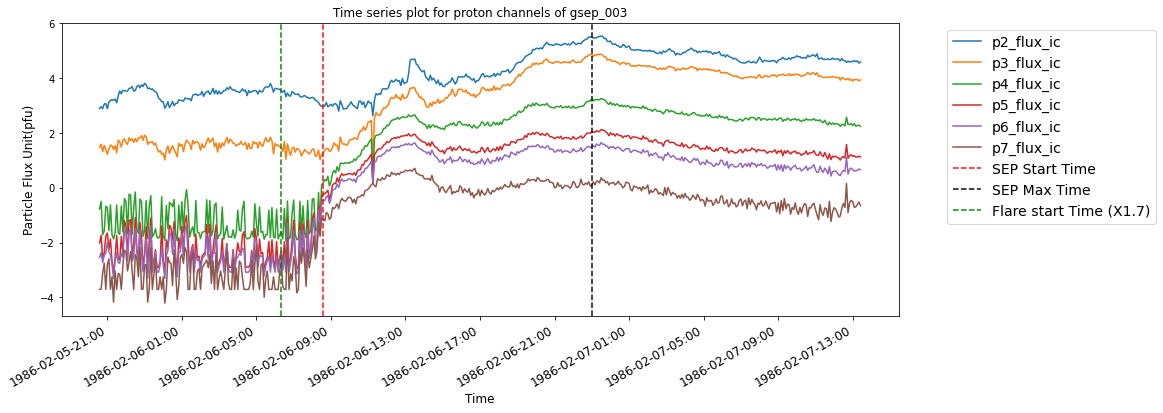

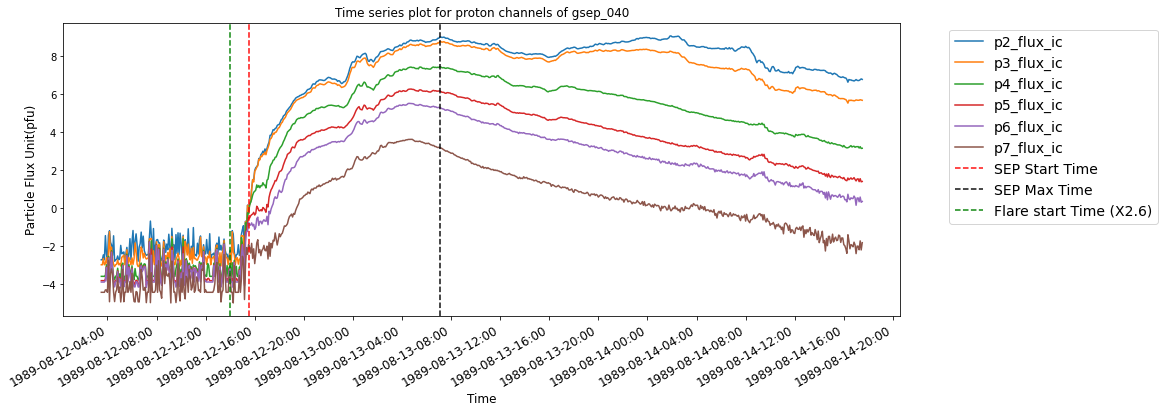

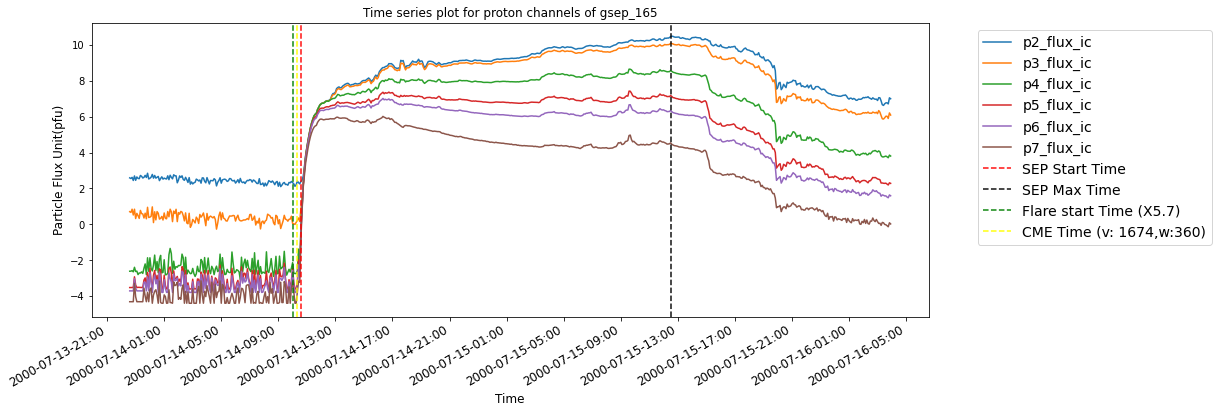

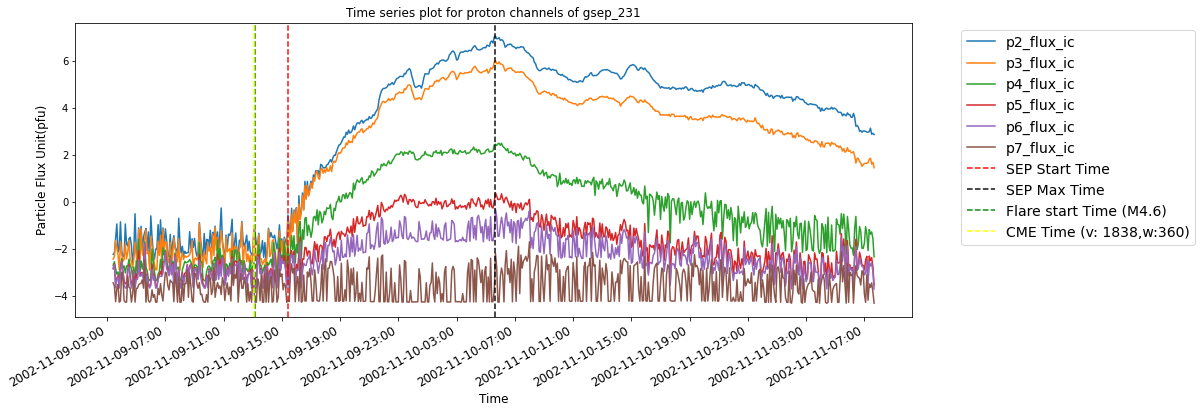

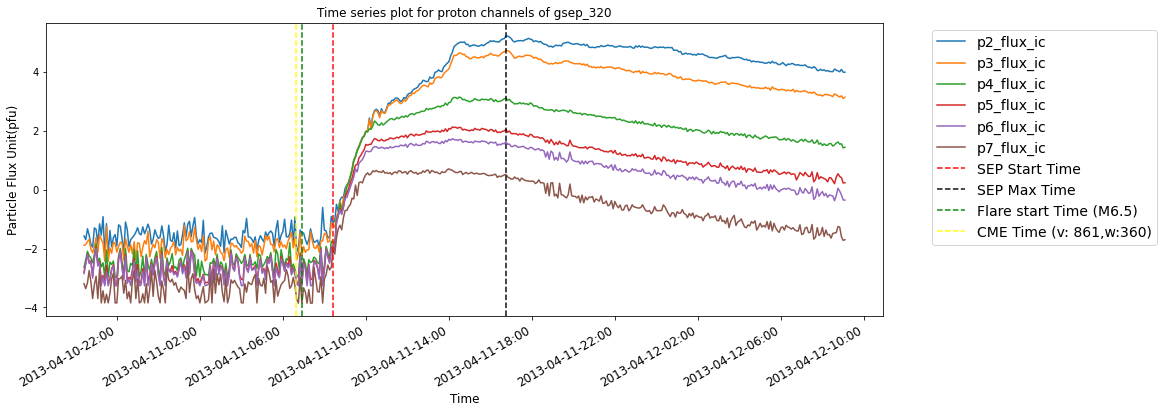

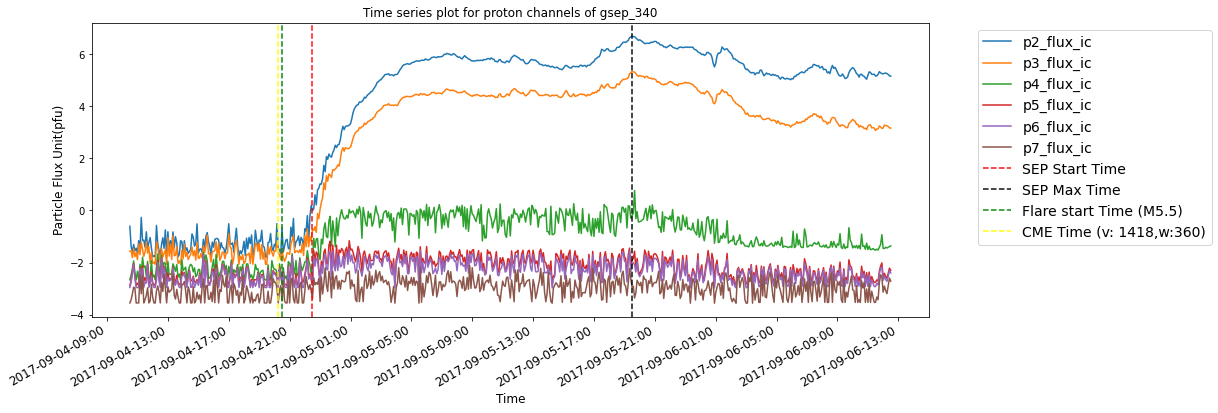

In [26]:
sep_list=['gsep_003','gsep_040','gsep_165','gsep_231','gsep_320','gsep_340']  ## list of SEP index for visualization
for sep_index in sep_list:
    time_series_df=time_series_slice_df(sep_ar_data,sep_index) # Function call to get time series
    time_series_df["time_stamp"]=pd.to_datetime(time_series_df["time_stamp"])
    time_series_df=time_series_df.set_index('time_stamp')
    visualize_ts(time_series_df,sep_ar_data,sep_index) ## Calling the visualization function
    
    
    

In [27]:
!pip list --format=freeze > requirements.txt
